# Method1 Huffman encoding

## Import Libraries

In [1]:
import mne
import numpy as np
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from sklearn.metrics import mean_squared_error
from math import sqrt
import os
import pandas as pd

In [2]:
acc = pd.read_csv('ACC.csv')
acc = acc.iloc[1:]
acc.columns = ['column1','column2','column3']
np.savetxt('acc.txt',acc)

In [3]:
sampling_freq = 1/32 
acc_c1 = acc["column1"]
acc_c2 = acc["column2"]
acc_c3 = acc["column3"]
acc_array_c1 = acc_c1.to_numpy() #save the data into an ndarray
acc_array_c2 = acc_c2.to_numpy()
acc_array_c3 = acc_c3.to_numpy()
acc_array_c1 = acc_array_c1[0:62000]  # Remove the signal in first 3minutes and last 5minutes
acc_array_c2 = acc_array_c2[0:62000]
acc_array_c3 = acc_array_c3[0:62000]
N = acc_array_c1.size
index = np.linspace(0, round((N-1)*sampling_freq,4), N)

## Butterworth Band pass Filter

In [4]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

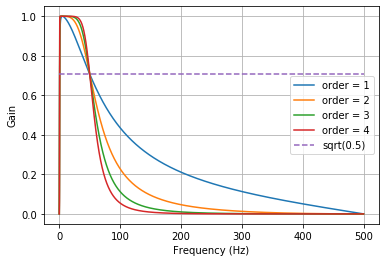

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import freqz

# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [6]:
y1 = butter_bandpass_filter(acc_array_c1, lowcut, highcut, fs, order=2)
y2 = butter_bandpass_filter(acc_array_c2, lowcut, highcut, fs, order=2)
y3 = butter_bandpass_filter(acc_array_c3, lowcut, highcut, fs, order=2)

## Resampling
It's not necessary for ACC data to be resampled because the sampling frequency is not high

In [7]:
from scipy import signal
#y = butter_bandpass_filter(ppg_array, lowcut, highcut, fs, order=2)
resampled_signal1 = y1 
resampled_signal2 = y2 
resampled_signal3 = y3 

In [8]:

np.savetxt('processed_acc_col1.txt',resampled_signal1)
np.savetxt('processed_acc_col2.txt',resampled_signal2)
np.savetxt('processed_acc_col3.txt',resampled_signal3)

## Round the signal and then do Huffman coding
The users can choose how many decimal they want to save in this case

In [9]:
round_signal1 = np.around(resampled_signal1,2) #Change the number of decimal here 
round_signal2 = np.around(resampled_signal2,2)
round_signal3 = np.around(resampled_signal3,2)
np.savetxt('acc_signal_rounded1.txt',round_signal1,fmt='%.2f')
np.savetxt('acc_signal_rounded2.txt',round_signal2,fmt='%.2f')
np.savetxt('acc_signal_rounded3.txt',round_signal3,fmt='%.2f')

### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr filename.txt" / "tcmpr filepath" to compress the file
4. Find the compressed file in the same directory of the original file

In [10]:
os.system('acc_signal_rounded1.txt')
os.system('acc_signal_rounded2.txt')
os.system('acc_signal_rounded3.txt')

32512

You could find a file name "acc_signal_rounded1.txt.huffman", "acc_signal_rounded2.txt.huffman", "acc_signal_rounded3.txt.huffman" in the current directory

### After this step, you could calculate the compression ratio if you want

## Decode the data

In [11]:
os.system('tcmpr -d acc_signal_rounded1.txt.huffman')
os.system('tcmpr -d acc_signal_rounded2.txt.huffman')
os.system('tcmpr -d acc_signal_rounded3.txt.huffman')

decoded_data_c1 = np.loadtxt(fname = "acc_signal_rounded1.txt")
decoded_data_c2 = np.loadtxt(fname = "acc_signal_rounded2.txt")
decoded_data_c3 = np.loadtxt(fname = "acc_signal_rounded3.txt")

Use Huffman coding to encode this normalized signal sequence.

Before Huffman coding, the size of the txt file of this signal sequence is 1238kB. After Huffman coding, the size of the txt file of this signal sequence is 522kB.

The original size of the raw data is 708kB in csv and 5.6MB in txt. If we calculate the compression ratio by the same data format. The compression ratio is 10.99


#### PRD calculation:


In [12]:
#resampled_signal_ori = signal.resample(ECG_array, 564001)

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import signal
# original_signal = normalized_signal
# compressed_signal = decoded_data
def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD1 = PRD_calculation(resampled_signal1, decoded_data_c1)
print("The PRD1 is {}%".format(round(PRD1*100,3)))
PRD2 = PRD_calculation(resampled_signal2, decoded_data_c2)
print("The PRD2 is {}%".format(round(PRD2*100,3)))
PRD3 = PRD_calculation(resampled_signal3, decoded_data_c3)
print("The PRD3 is {}%".format(round(PRD3*100,3)))

The PRD1 is 0.031%
The PRD2 is 0.02%
The PRD3 is 0.021%


## Plot a part of signal to see the difference

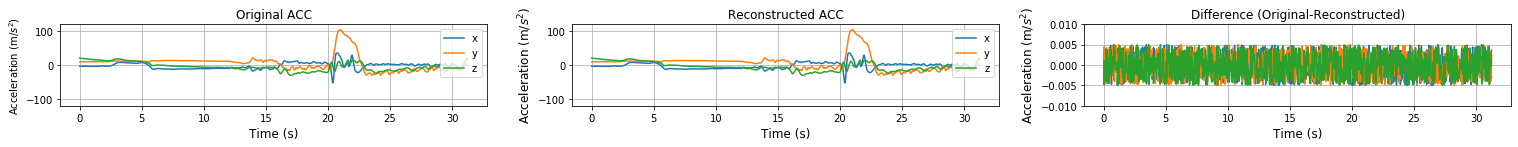

In [14]:
time_index = np.linspace(0,31.25,1000)
fig, ax = plt.subplots(1,3, figsize = (26,1.5))

ax[0].plot(time_index, resampled_signal1[15000:16000], label = "x")
ax[0].plot(time_index, resampled_signal2[15000:16000], label = "y")
ax[0].plot(time_index, resampled_signal3[15000:16000], label = "z")
ax[0].grid()
ax[0].legend(loc = 'upper right')
ax[0].set_title("Original ACC")
ax[0].set_xlabel("Time (s)", size = 12)
ax[0].set_ylabel("Acceleration (m/$s^2$)")
ax[0].set_ylim(-120,120)


ax[1].plot(time_index, decoded_data_c1[15000:16000], label = "x")
ax[1].plot(time_index, decoded_data_c2[15000:16000], label = "y")
ax[1].plot(time_index, decoded_data_c3[15000:16000], label = "z")
ax[1].grid()
ax[1].legend(loc = 'upper right')
ax[1].set_title("Reconstructed ACC")
ax[1].set_xlabel("Time (s)", size = 12)
ax[1].set_ylabel("Acceleration (m/$s^2$)", size = 12)
ax[1].set_ylim(-120,120)

ax[2].plot(time_index,(resampled_signal1[15000:16000]-decoded_data_c1[15000:16000]), label = "Difference")
ax[2].plot(time_index,(resampled_signal2[15000:16000]-decoded_data_c2[15000:16000]), label = "Difference")
ax[2].plot(time_index,(resampled_signal3[15000:16000]-decoded_data_c3[15000:16000]), label = "Difference")
ax[2].grid()
ax[2].set_title("Difference (Original-Reconstructed)")
ax[2].set_xlabel("Time (s)", size = 12)
ax[2].set_ylabel("Acceleration (m/$s^2$)", size = 12)
ax[2].set_ylim(-0.01,0.01)

plt.savefig('acc_huffman.png',dpi=300,bbox_inches = "tight")

In [15]:
rec1 = decoded_data_c1[15000:16000]
ori1 = resampled_signal1[15000:16000]
np.savetxt('x_acc.txt',time_index)
np.savetxt("rec1_acc.txt",rec1)
np.savetxt("ori1_acc.txt",ori1)

rec2 = decoded_data_c2[15000:16000]
ori2 = resampled_signal2[15000:16000]
np.savetxt("rec2_acc.txt",rec2)
np.savetxt("ori2_acc.txt",ori2)

rec3 = decoded_data_c3[15000:16000]
ori3 = resampled_signal3[15000:16000]
np.savetxt("rec3_acc.txt",rec3)
np.savetxt("ori3_acc.txt",ori3)